# Neural Machine Translation with CrossAttention

Inspired highly on the tutorial [NMT with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) which takes the code from the original Seq2Seq with MHA attention [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015).

## Prep


### Installations and imports

In [ ]:
# Everytime I run these notebooks I get the following warning:
# "The selected GPU type was not available. You are now connected to a T4".
# It seems that's something set in the notebook settings as it offers me to open it

!pip install -U nltk 'tensorflow-text' 'keras-nlp' 'keras-preprocessing' # changed 'tensorflow-text==2.15.0' to just 'tensorflow-text' as version 2.15.0 is not available

# added to fix the "ModuleNotFoundError: No module named 'sklearn.model_szelection" error in the next cell
#!pip uninstall -y scikit-learn
#!pip install scikit-learn
#import sklearn
# Finally realized the problem was the spelling of selection

!pip install gensim # Because in Demo1 and 2 I use this to resolve the "ModuleNotFoundError: No module named 'gensim'" error

In [ ]:
# Used this to check sklearn version, but I finally resolved by changes the import to tensorflow.keras.preprocessing.text import Tokenizer
import sklearn
print (sklearn.__version__)

1.6.1


In [ ]:
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing import sequence
# to fix the "No module named 'keras.preprocessing.text'" error I commented the following line and added the next one
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import preprocessing
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
# I tried to remove the experimental part (as in Demo2), but it did not work, so I commented the line for now
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model, Input
import tensorflow_text as tf_text
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import time

# Filter out warnings to keep the output clean during execution.
warnings.filterwarnings('ignore')
# Download the 'punkt' tokenizer from nltk, which is essential for tokenizing text into sentences or words.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Download and prepare the dataset

The steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.


In [ ]:
# Use the %%writefile magic command to write the following lines to a file named get_data.sh.
# The %%writefile magic command is a built-in command in Jupyter notebooks and Colab
# that allows you to write the content of the cell to a specified file.
%%writefile get_data.sh
# Check if the file spa.txt does not exist
if [ ! -f spa.txt ]; then
  # If spa.txt does not exist, download it from the given URL and save it as spa.txt
  wget -O spa.txt https://www.dropbox.com/s/ke42pnpydmy6oa6/spa.txt?dl=0
fi

Writing get_data.sh


In [ ]:
!bash get_data.sh

--2025-10-04 19:38:25--  https://www.dropbox.com/s/ke42pnpydmy6oa6/spa.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5ovf4txnjfzcxt3ylskex/spa.txt?rlkey=t54t9t6txhoddwk0lfk6te9t5&dl=0 [following]
--2025-10-04 19:38:26--  https://www.dropbox.com/scl/fi/5ovf4txnjfzcxt3ylskex/spa.txt?rlkey=t54t9t6txhoddwk0lfk6te9t5&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0cd1422130edd7acef106f7507.dl.dropboxusercontent.com/cd/0/inline/CykU2geqC_9rdxblq48t_psd4346YhQdZVQpPK4cg3fDMw_fvdNjox0-K0mSMR6WauFNUhhhS5QbyG1fRcTheSbmhuqDo1GL3vyAcYyOwlmyBWogx6FVb0gAWUzsFmGeDMwyMGz_P38569csSkgwn8MJ/file# [following]
--2025-10-04 19:38:27--  https://uc0cd1422130edd7acef106f7507.dl.dropboxusercontent.com/cd/0/inlin

In [ ]:
! head spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [ ]:
def load_data(path):
  # Read the text file from the given path with utf-8 encoding.
  text = path.read_text(encoding='utf-8')

  # Split the text into lines.
  lines = text.splitlines()
  # Split each line by the tab character to create pairs of source and target sentences.
  pairs = [line.split('\t') for line in lines]
  # Example: If a line is "Hello\tHola", pairs will contain ["Hello", "Hola"]
  # If the input text was "Go.\tVe.\nHi.\tHola.", the pairs variable would be [['Go.', 'Ve.'], ['Hi.', 'Hola.']]

  # Extract the context sentences (second element of each pair) into a NumPy array.
  # The `for target, context in pairs` loop iterates through each pair in the `pairs` list,
  # assigning the first element to `target` and the second to `context` for each iteration.
  # Example: Using the previous pairs example [['Go.', 'Ve.'], ['Hi.', 'Hola.']], context would be np.array(['Ve.', 'Hola.'])
  context = np.array([context for target, context in pairs])
  # Extract the target sentences (first element of each pair) into a NumPy array.
  # Similar to the previous line, the loop iterates through the `pairs` list.
  # Example: Using the previous pairs example [['Go.', 'Ve.'], ['Hi.', 'Hola.']], target would be np.array(['Go.', 'Hi.'])
  target = np.array([target for target, context in pairs])

  # Return the target and context arrays.
  return target, context

In [ ]:
import pathlib
target_raw, context_raw = load_data(pathlib.Path('./spa.txt'))
print(context_raw[-1])
print(context_raw[0:5])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
['Ve.' 'Vete.' 'Vaya.' 'Váyase.' 'Hola.']


In [ ]:
print(target_raw[-1])
print(target_raw[200:205])
print(target_raw[-5:-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.
['Back off.' 'Be a man.' 'Be brave.' 'Be brief.' 'Be brief.']
['There are four main causes of alcohol-related death. Injury from car accidents or violence is one. Diseases like cirrhosis of the liver, cancer, heart and blood system diseases are the others.'
 "There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college education."
 'A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.'
 'Since there are usually multiple websites on any given topic, I usually just 

In [ ]:
# Set the buffer size for shuffling the dataset to the total number of samples.
BUFFER_SIZE = len(context_raw)
# Set the batch size for training.
BATCH_SIZE = 64

# Create a boolean array to randomly split the data into training (80%) and validation (20%) sets.
# np.random.uniform generates random numbers between 0 and 1.
# The comparison "< 0.8" is applied element-wise to the array generated by np.random.uniform.
# This results in a boolean array where True indicates the element is included in the training set (approximately 80% of the data).
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8
# Example: If len(target_raw) was 5, is_train could look like: [ True, False, True, True, False]

# Create a TensorFlow Dataset for the training data.
# .from_tensor_slices() creates a dataset from the slices of the given tensors.
# When a boolean array like `is_train` is used to index a NumPy array (e.g., `context_raw[is_train]`),
# it selects only the elements from `context_raw` where the corresponding value in `is_train` is True.
# .shuffle(BUFFER_SIZE) shuffles the elements of the dataset with a buffer of size BUFFER_SIZE.
# .batch(BATCH_SIZE) combines consecutive elements into batches of size BATCH_SIZE.
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
# Create a TensorFlow Dataset for the validation data.
# ~is_train selects the elements that are not in the training set.
# Similar to the training set, `context_raw[~is_train]` selects elements where `is_train` is False.
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Es tan agradable quedarse en casa.'
 b'De ninguna manera lo aceptar\xc3\xa9.' b'Fui a Boston en coche.'
 b'Tom le pidi\xc3\xb3 a Mary que le hiciera algo de comer.'
 b'Tom no se merece otra oportunidad.'], shape=(5,), dtype=string)

tf.Tensor(
[b"It's so nice to stay at home." b'By no means will I accept it.'
 b'I went to Boston by car.'
 b'Tom asked Mary to make him something to eat.'
 b"Tom doesn't deserve another chance."], shape=(5,), dtype=string)


### Text processing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


### Text Vectorization


Here comes the key part, using the layer TextVectorization we provide how to process text and how to construct the vocabulary, which we will later refer back

In [ ]:
max_vocab_size = 5000 # Define the maximum vocabulary size.

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, # Specify the function to use for text standardization.
    max_tokens=max_vocab_size, # Set the maximum number of tokens (vocabulary size).
    ragged=True) # Output ragged tensors, which can have varying lengths.

In [ ]:
 # Adapt the text processor to the training context data.
 # This step analyzes the data to build the vocabulary based on the unique tokens found.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10] # Get the first 10 words from the built vocabulary.

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

notice we passed to ids, not padded yet

In [ ]:
# Convert the example context strings to tokens using the context text processor.
# The result is a ragged tensor because the input strings have varying lengths after processing.
example_tokens = context_text_processor(example_context_strings)
# Display the first 3 rows of the example tokens, showing the token IDs for the first few context strings.
example_tokens[:3, :]

<tf.RaggedTensor [[2, 15, 65, 1122, 934, 14, 51, 4, 3], [2, 6, 502, 463, 22, 1, 4, 3],
 [2, 274, 8, 135, 14, 155, 4, 3]]>

tf.Tensor(
[[   2   15   65 1122  934   14   51    4    3    0    0    0    0    0
     0    0]
 [   2    6  502  463   22    1    4    3    0    0    0    0    0    0
     0    0]
 [   2  274    8  135   14  155    4    3    0    0    0    0    0    0
     0    0]], shape=(3, 16), dtype=int64)


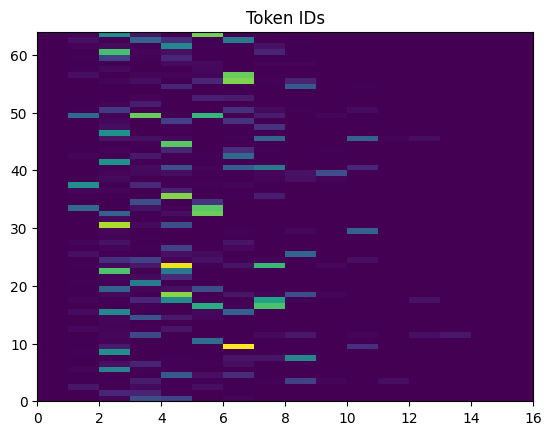

In [ ]:
# Convert the ragged tensor of example tokens to a dense tensor, padding with 0s where necessary.
# A ragged tensor has sequences of varying lengths, while a dense tensor has sequences of the same length, padded with a value (usually 0).
# This is required for plotting with pcolormesh, which expects a dense, rectangular grid of data.
plt.pcolormesh(example_tokens.to_tensor())
print(example_tokens.to_tensor()[:3, :])
# Set the title of the plot.
plt.title('Token IDs')
# Display the plot.
plt.show() # Added show() to display the plot explicitly
# The plot shows the token IDs as a pseudocolor plot. Each row represents a sentence, and the color intensity corresponds to the token ID.
# Padding tokens (with ID 0) are typically shown in a distinct color or are absent.

### Process the dataset



The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.


In [ ]:
# Function to process the text data
def process_text(context, target):
  # Convert context text to token IDs using the context text processor and convert to a dense tensor
  # Context is converted to a dense tensor immediately because the encoder processes the entire sequence at once.
  context = context_text_processor(context).to_tensor()
  # Convert target text to token IDs using the target text processor (result is a ragged tensor)
  # .to_tensor() is not used here because target_text_processor is configured to output ragged tensors (ragged=True).
  # The slicing operations target[:,:-1] and target[:,1:] work directly on the ragged tensor before converting to dense tensors.
  target = target_text_processor(target)
  # Extract target input sequence (all tokens except the last one) and convert to a dense tensor
  targ_in = target[:,:-1].to_tensor()
  # Extract target output sequence (all tokens except the first one) and convert to a dense tensor
  targ_out = target[:,1:].to_tensor()
  # Return the input pair ((context, targ_in)) and the output (targ_out) for training
  return (context, targ_in), targ_out

# Apply the process_text function to the training raw dataset.
# This transforms the raw training data (strings) into processed tensors (token IDs).
# tf.data.AUTOTUNE allows TensorFlow to automatically tune the number of parallel calls for mapping.
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
# Apply the process_text function to the validation raw dataset.
# This transforms the raw validation data (strings) into processed tensors (token IDs), similar to the training data.
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
# Iterate through the first element (batch) of the training dataset.
# train_ds.take(1) gets a single batch from the dataset.
# The batch is a tuple: ((context_tokens, target_input_tokens), target_output_tokens)
# The for loop unpacks this tuple into the variables:
# (ex_context_tok, ex_tar_in): This is the input to the model, a tuple containing context tokens and target input tokens.
# ex_tar_out: This is the expected output (labels) for the model, containing target output tokens.
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  # Print the first 10 token IDs of the first context sequence in the batch.
  print(ex_context_tok[0, :10].numpy())
  print() # Print a blank line for better readability.
  # Print the first 10 token IDs of the first target input sequence in the batch.
  print(ex_tar_in[0, :10].numpy())
  # Print the first 10 token IDs of the first target output sequence (labels) in the batch.
  print(ex_tar_out[0, :10].numpy())
  break # Stop after processing the first batch.

[  2  13  53   1   6 135  12   3   0   0]

[  2  69  56   8  80 118  68 168  11   0]
[ 69  56   8  80 118  68 168  11   3   0]


## The encoder/decoder

<table><tr>  <td>   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>  </td>  <td>   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>  </td></tr><tr>  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>  <th colspan=1>This tutorial's model</th><tr></table>

In [ ]:
UNITS = 256

#### Encoder

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super().__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    # It maps integer token IDs to dense vectors of fixed size (units).
    # mask_zero=True: Specifies that the padding value (0) should be masked out,
    # meaning the embedding layer will not produce an output for the padding token,
    # and subsequent layers will ignore these masked values.
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    # Bidirectional wrapper: Makes the GRU layer process the input sequence in both forward and backward directions.
    # merge_mode='sum': The outputs from the forward and backward GRU layers are summed.
    # GRU (Gated Recurrent Unit): A type of recurrent neural network layer that processes sequences and maintains an internal state.
    # units: The number of units in the GRU layer, which determines the dimensionality of the output space.
    # return_sequences=True: The GRU layer returns the hidden state output for each time step in the input sequence.
    # recurrent_initializer='glorot_uniform': Initializes the recurrent weights using the Glorot uniform initializer,
    # which helps in preventing vanishing/exploding gradients during training.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # The call method defines the forward pass of the encoder layer.
    # x: Input tensor (token IDs).

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    # The bidirectional GRU processes the embedded sequence and returns a new sequence of combined outputs.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings (encoder output).
    return x

  def convert_input(self, texts):
    # This function is used to process raw text inputs for translation.
    # texts: A tensor of raw text strings.

    # Convert the input texts to a TensorFlow tensor.
    texts = tf.convert_to_tensor(texts)
    # If the input is a single string (scalar tensor), add a batch dimension.
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    # Process the texts using the text processor to get token IDs and convert to a dense tensor.
    context = self.text_processor(texts).to_tensor()
    # Pass the token IDs through the encoder layer (calls the self.call method).
    context = self(context)
    # Return the encoded context.
    return context

In [ ]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 24)
Encoder output, shape (batch, s, units): (64, 24, 256)


#### Attention


<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    # MultiHeadAttention layer for computing attention weights.
    # key_dim: The dimensionality of the key vectors.
    # num_heads: The number of attention heads.
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    # LayerNormalization layer for normalizing the output.
    self.layernorm = tf.keras.layers.LayerNormalization()
    # Add layer for residual connection.
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    # Compute multi-head attention.
    # query: The query tensor (e.g., decoder output).
    # value: The value tensor (e.g., encoder output).
    # return_attention_scores: If True, also returns the attention scores.
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    # Reduce the mean across the attention heads (axis=1).
    # tf.reduce_mean calculates the mean of elements across the specified axis of a tensor.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    # Apply residual connection and layer normalization.
    x = self.add([x, attn_output])  # Residual Connection: Adds the input x to the attention output.
    x = self.layernorm(x) # Normalize the combined output.

    # Return the output after attention, residual connection, and normalization.
    return x

In [ ]:
# Create an instance of the CrossAttention layer with the specified number of units.
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
# Create an Embedding layer for the target text.
# target_text_processor.vocabulary_size(): Gets the size of the target vocabulary.
# output_dim=UNITS: Sets the dimensionality of the embedding vectors to the same number of units as the encoder and attention layer.
# mask_zero=True: Specifies that the padding value (0) should be masked out.
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
# Embed the example target input tokens.
ex_tar_embed = embed(ex_tar_in)

# Apply the attention layer to the embedded target tokens and the encoder output (context).
# The attention layer calculates attention weights and produces an output that is a weighted sum of the context based on the target.
result = attention_layer(ex_tar_embed, ex_context)

# Print the shapes of the input and output tensors to understand the dimensions.
print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

# Outputs Explanation:
# Context sequence shape: (batch_size, source_sequence_length, units) - The output of the encoder.
# Target sequence shape: (batch_size, target_sequence_length, units) - The embedded target input tokens.
# Attention result shape: (batch_size, target_sequence_length, units) - The output of the attention layer, same shape as the target sequence.
# Attention weights shape: (batch_size, target_sequence_length, source_sequence_length) - The attention weights, indicating how much each target token attends to each source token.

Context sequence, shape (batch, s, units): (64, 24, 256)
Target sequence, shape (batch, t, units): (64, 22, 256)
Attention result, shape (batch, t, units): (64, 22, 256)
Attention weights, shape (batch, t, s):    (64, 22, 24)


In [ ]:
# Calculate the sum of attention weights across the source sequence (axis=-1) for the first example in the batch (index 0).
# The sum should be approximately 1 for each target token, indicating that the attention weights are normalized across the source sequence.
# The output is an array where each value corresponds to a target token and represents the sum of its attention weights over all source tokens.
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.0000001 , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

#### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, text_processor, units):
    super().__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

  def call(self, context, x, state=None, return_state=False):

    # 1. Lookup the embeddings
    x = self.embedding(x)

    # 2. Process the target sequence.
    # Handle initial state correctly when it's None
    # if else statement added by Gemini, because I got the following error in the next-next cell:
    # "Exception encountered when calling Decoder.call(). too many values to unpack (expected 2"
    # Gemini said:
    # "The error ValueError: too many values to unpack (expected 2) in cell _TJ-zsUczJyW occurs in the Decoder's call method when
    # calling the GRU layer. This is because the GRU layer is configured to return both the sequence of outputs and the final state
    # (return_sequences=True, return_state=True). The code attempts to unpack these two outputs into x and state. The issue arises
    # when initial_state is None in the first call, which causes the GRU's behavior to differ slightly in how it returns the state.
    # To fix this, I will modify the Decoder's call method in cell pCyAFrEN-_RV to handle the initial state correctly when it's None.
    # I will check if state is None and pass initial_state=None to the GRU call accordingly."

    # I still kept getting the error, so I'll just follow the video
    if state is None:
      x, state = self.rnn(x)
    else:
      x, state = self.rnn(x, initial_state=state)

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)

    if return_state:
      return logits, state
    else:
      return logits

# Stuff we will need for inference

  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    # GRU layer's get_initial_state returns a tuple of states
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True)

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, t, target_vocabulary_size) {logits.shape}')

ValueError: Exception encountered when calling Decoder.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by Decoder.call():
  • context=tf.Tensor(shape=(64, 24, 256), dtype=float32)
  • x=tf.Tensor(shape=(64, 22), dtype=int64)
  • state=None
  • return_state=False

### The model

In [ ]:
class Translator(tf.keras.Model):

  def __init__(self, units, context_text_processor, target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)
    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)
    return logits

  def translate(self, texts, *, max_length=50, temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)

      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

In [ ]:
logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

In [ ]:
model.summary()

## Training

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=25,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translate

In [ ]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

In [ ]:
def plot_attention(model, text, **kwargs):
  assert isinstance(text, str)
  output = model.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = model.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
plot_attention(model, '¿Todavía está en casa?')

In [ ]:
plot_attention(model, 'Esta es mi vida.')

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

In [ ]:
result = model.translate([long_text])
result[0].numpy().decode()

In [ ]:
plot_attention(model, long_text)